In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, GlobalAveragePooling2D, Dense, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

# Model Architecture
def build_uniscriptnet(input_shape=(32, 32, 1), num_classes=47):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Block
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Increased from 0.2
    
    # Residual Block 1
    shortcut = x
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)  # Removed kernel_regularizer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Increased from 0.2
    
    # Residual Block 2
    shortcut = x
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)  # Removed kernel_regularizer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.35)(x)  # Increased from 0.3
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

print("Model initialized successfully")

Model initialized successfully


In [8]:
# Cosine Annealing Learning Rate Schedule
def cosine_annealing_schedule(epoch, max_lr=1e-3, min_lr=1e-5, T_max=10):
    t = epoch % T_max
    lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * t / T_max))
    return lr

# Label Smoothing Loss
def categorical_crossentropy_with_label_smoothing(y_true, y_pred, label_smoothing=0.1):
    y_true = y_true * (1.0 - label_smoothing) + (label_smoothing / K.cast(K.shape(y_true)[-1], K.floatx()))
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

In [9]:
import pandas as pd
import cv2
from tqdm import tqdm

# ---------------------------------------------
# Step 2: Convert EMNIST CSV to Image Folders (32x32)
# ---------------------------------------------
def save_emnist_images(csv_path, output_dir, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Rotate + flip to fix EMNIST orientation
        image = np.transpose(image, (1, 0))
        image = cv2.flip(image, 0)

        # Resize to 32x32
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# Convert train and test CSVs to image folders
save_emnist_images('/kaggle/input/emnist/emnist-balanced-train.csv', 'emnist_balanced_images/train')
save_emnist_images('/kaggle/input/emnist/emnist-balanced-test.csv', 'emnist_balanced_images/test')


100%|██████████| 18800/18800 [00:03<00:00, 5161.73it/s]


In [10]:
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 80
num_classes = 47  # Update if using fewer classes

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,              # Safe for all
    width_shift_range=0.05,         
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,              # Safe for all
    width_shift_range=0.05,         
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False
)
train_generator = train_datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=33,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'emnist_balanced_images/test',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=33,
    shuffle=False
)

Found 112800 images belonging to 47 classes.
Found 18800 images belonging to 47 classes.


In [11]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_uniscriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=categorical_crossentropy_with_label_smoothing,
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749500281.739989      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749500281.740621      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 16, 16, 32)     │            320 │ dropout[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 32)     │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 64)       │              0 │ max_pooling2d_1[0][0]  │
├──────────────────────

 Total params: 69,551 (271.68 KB)

 Trainable params: 68,399 (267.18 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [12]:
# ----------------------------
# 4. Train Model
# ----------------------------
# Callbacks
callbacks = [
    LearningRateScheduler(cosine_annealing_schedule),
    EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("uniscriptnet_EMNIST_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Training
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749500313.304365     117 service.cc:148] XLA service 0x787c0c005150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749500313.306014     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749500313.306036     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749500314.152722     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1763 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.0148 - loss: 4.7925 

I0000 00:00:1749500321.741059     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1762/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2759 - loss: 3.0325
Epoch 1: val_accuracy improved from -inf to 0.64824, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 94s 44ms/step - accuracy: 0.2761 - loss: 3.0318 - val_accuracy: 0.6482 - val_loss: 1.7576 - learning_rate: 0.0010
Epoch 2/80
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7062 - loss: 1.6585
Epoch 2: val_accuracy improved from 0.64824 to 0.81277, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.7062 - loss: 1.6585 - val_accuracy: 0.8128 - val_loss: 1.3355 - learning_rate: 9.7577e-04
Epoch 3/80
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7638 - loss: 1.4842
Epoch 3: val_accuracy improved from 0.81277 to 0.82319, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - accuracy: 0.7638 - loss: 1.4842 - val_accuracy: 0.8232 - val_loss: 1.2884 - learning_rate: 8.8355e-04
Epoc

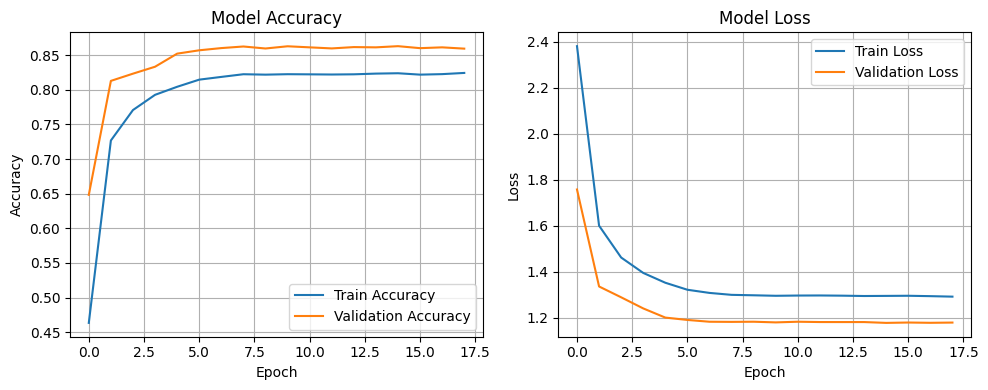

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

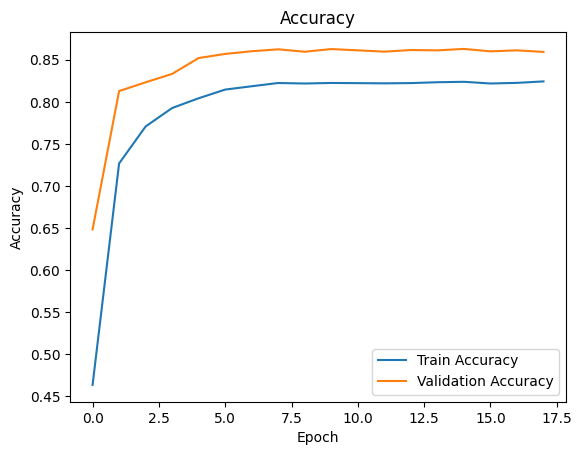

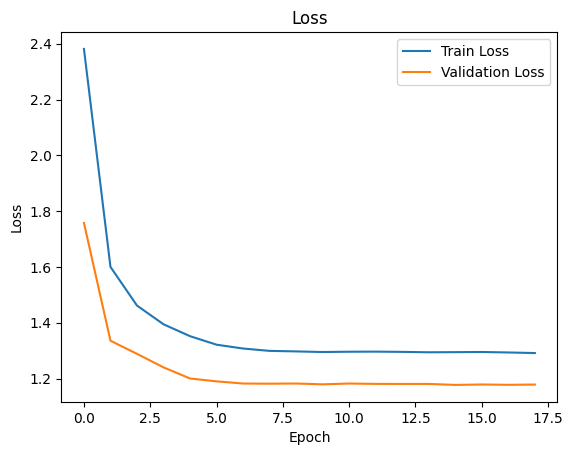

294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8318 - loss: 1.2131
Final Validation Accuracy: 85.98%


In [14]:
# Visualize Training Metrics
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Validation Set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")

294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


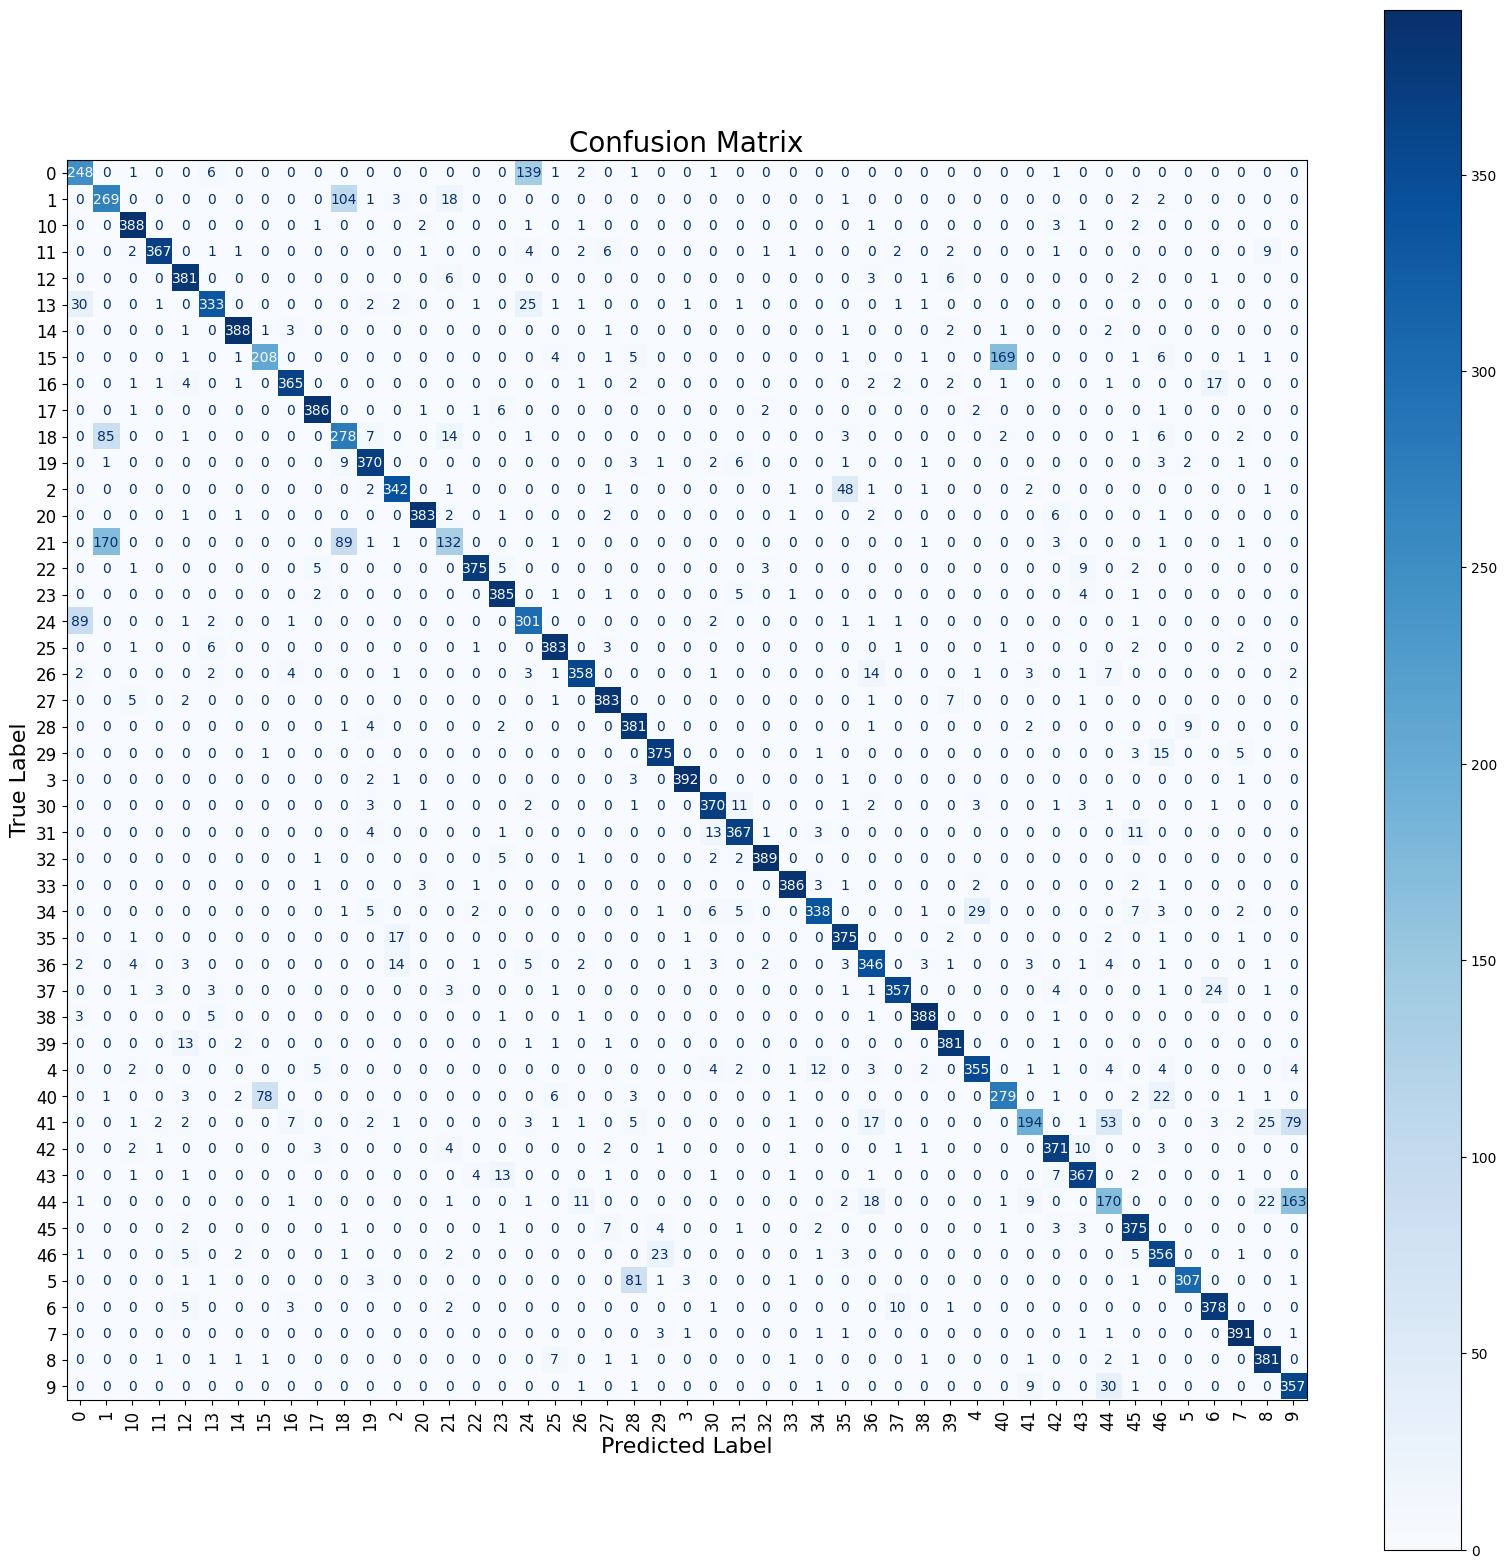

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


In [16]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.6486    0.6000    0.6234       400
           1     0.5009    0.6925    0.5813       400
          10     0.9375    0.9750    0.9559       400
          11     0.9735    0.9200    0.9460       400
          12     0.8907    0.9575    0.9229       400
          13     0.9359    0.8400    0.8854       400
          14     0.9673    0.9625    0.9649       400
          15     0.7177    0.5275    0.6081       400
          16     0.9544    0.8900    0.9211       400
          17     0.9673    0.9625    0.9649       400
          18     0.5876    0.6875    0.6336       400
          19     0.9165    0.9325    0.9244       400
           2     0.9081    0.8650    0.8860       400
          20     0.9795    0.9575    0.9684       400
          21     0.7184    0.3125    0.4355       400
          22     0.9792    0.9425    0.9605       400
          23